# Scaling monosemanticity

In [1]:
# Required installations for transformers and datasets
!pip install transformers datasets
!pip install keras huggingface_hub
!pip install tensorflow
!pip install python-dotenv
!pip install zstandard
#!pip install bitsandbytes

In [10]:

import os
from dotenv import load_dotenv
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from huggingface_hub import login
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from transformers import BitsAndBytesConfig

## Transformer activations - LLaMA 3.2 3B

In [3]:
load_dotenv()
hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/drew99/.cache/huggingface/token
Login successful


In [4]:

# # Hugging Face Login (get token from os environment)
# login(os.getenv("HF_ACCESS_TOKEN"))

# notebook_login()


# Could also later use 
# tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)

In [5]:

# Load the LLaMA 3.2B model without quantization (for now)
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device) # 16-bit precision

# Some other LLaMA models to try:
# https://huggingface.co/meta-llama/Llama-3.2-3B"
# https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct-QLORA_INT4_EO8
# https://huggingface.co/mradermacher/Fireball-Meta-Llama-3.2-8B-Instruct-agent-003-128k-code-DPO-i1-GGUF  i1-Q4_K_M
# https://huggingface.co/TheBloke/Llama-2-7B-Chat-GPTQ

# Prepare 4-bit quantization configuration (optional)
# Uncomment the following lines if you wish to use quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You shouldn't move a model that is dispatched using accelerate hooks.


In [6]:
print(model.model.layers) # Specific to LLaMA model # https://huggingface.co/docs/transformers/main/model_doc/llama#transformers.LlamaForCausalLM

ModuleList(
  (0): LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
      (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
      (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
      (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
      (rotary_emb): LlamaRotaryEmbedding()
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
      (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
      (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
  )
  (1): LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
      (k_proj): Linear4bit(in_f

In [7]:
activation_cache = []
def save_activations_hook(module, input, output):
    # input is a tuple; input[0] is the tensor we need
    activation_cache.append(input[0].cpu().detach().numpy())

# Register hook on the 16th layer
layer_index = 15  # Zero-based index; 15 corresponds to the 16th layer
hook_handle = model.model.layers[layer_index].register_forward_hook(save_activations_hook) 
# for other models, you may need to use model.transformer.h[15] instead of model.model.layers[15]


In [8]:

# Example input
input_text = "Your input text here."
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

# Access the residual stream activation
residual_stream = activation_cache[0]
print(f"Residual stream shape at layer {layer_index+1}: {residual_stream.shape}")

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Residual stream shape at layer 16: (1, 6, 3072)


In [9]:
# Load the first 30 million examples from 'The Pile' dataset 
# https://huggingface.co/docs/datasets/loading#slice-splits
# data_len = 30_000_000
data_len = 10_000
# split_str = f"train[:{data_len}]"
dataset = load_dataset("monology/pile-uncopyrighted", split="train", streaming=True)

# Set up processing parameters
os.makedirs("activations_data", exist_ok=True)

# Initialize accumulators and parameters
batch_size = 8 # number of sentences in a batch
file_size = 10*8192 # number of examples in a file
files_saved = 0
batch_texts = []
activation_cache = [] # cache of activations for a batch
all_data = np.empty((0, 3075), dtype=np.float16)  # 3072 + 3 (sent_idx, token_idx, token)

# Create batches from the dataset
print("Processing dataset and saving activations in batches...")
for i, example in enumerate(dataset):
    batch_texts.append(example['text'])
    
    if (i + 1) % batch_size == 0 or i + 1 >= data_len:
        # Process full batch or final partial batch
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            max_length=512,
            padding="max_length",
        ).to(device)
        
        with torch.no_grad():
            model(**inputs)
        
        # Convert activation_cache to numpy array and reshape
        batch_activations = np.array(activation_cache)
        
        # Reshape batch_activations from (1, 8, 42, 3072) to (8*42, 3072)
        batch_activations = batch_activations.reshape(batch_activations.shape[1] * batch_activations.shape[2], -1)

        # Create sentence index array (sent_idx) and token index array (token_idx)
        # sent_idx = [1 1 1 1 1; 2 2 2 2 2; 3 3 3 3 3; ...]
        # token_idx = [1 2 3 4 5; 1 2 3 4 5; 1 2 3 4 5; ...]
        num_sentences, num_tokens = inputs['attention_mask'].shape # (8, 42)
        sent_idx = np.repeat(np.arange(1, num_sentences + 1), num_tokens).reshape(-1, 1)  # Shape: (8*42, 1)
        sent_idx = sent_idx + (i - batch_size) # offset by batch index
        token_idx = np.tile(np.arange(1, num_tokens + 1), num_sentences).reshape(-1, 1)    # Shape: (8*42, 1)
        token_idx = token_idx - 1 # offset by 1
        # also save tokens id from tokenizer
        tokens = inputs['input_ids'].cpu().numpy().reshape(-1, 1)
                
        # Stack activations, sent_idx, and token_idx
        batch_activations = np.hstack((batch_activations, sent_idx, token_idx, tokens)).astype(np.float16)

        # Remove rows where attention mask is 0
        attention_mask = inputs['attention_mask'].cpu().numpy().reshape(-1)
        batch_activations = batch_activations[attention_mask != 0]

        # Stack to all_data
        all_data = np.vstack((all_data, batch_activations))
        print(f"all_data shape: {all_data.shape}")

        # Save to file if file_size limit is reached
        if all_data.shape[0] >= file_size:
            data_to_save = all_data[:file_size, :]
            np.save(f"activations_data/activations_batch_{files_saved}.npy", data_to_save)
            files_saved += 1
            print(f"Saved file {files_saved} == {file_size*files_saved} examples")
            all_data = all_data[file_size:, :]  # Retain any remaining rows
            
        # Reset for next batch
        batch_texts = []
        activation_cache = []

    if i + 1 >= data_len:
        break

# Save any remaining data
if all_data.shape[0] > 0:
    np.save(f"activations_data/activations_batch_{files_saved}.npy", all_data)
    del all_data

print("Finished processing and saving all batches")



Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Processing dataset and saving activations in batches...


/tmp/ipykernel_11006/2903579871.py:55: RuntimeWarning: overflow encountered in cast
  batch_activations = np.hstack((batch_activations, sent_idx, token_idx, tokens)).astype(np.float16)


all_data shape: (2910, 3075)
all_data shape: (5254, 3075)
all_data shape: (7698, 3075)
all_data shape: (10530, 3075)
all_data shape: (13452, 3075)
all_data shape: (16771, 3075)
all_data shape: (19101, 3075)
all_data shape: (21961, 3075)
all_data shape: (24559, 3075)
all_data shape: (27488, 3075)
all_data shape: (30681, 3075)
all_data shape: (32968, 3075)
all_data shape: (35208, 3075)
all_data shape: (37700, 3075)
all_data shape: (40361, 3075)
all_data shape: (43586, 3075)
all_data shape: (46561, 3075)
all_data shape: (49329, 3075)
all_data shape: (52517, 3075)
all_data shape: (55162, 3075)
all_data shape: (58179, 3075)
all_data shape: (61216, 3075)
all_data shape: (64546, 3075)
all_data shape: (67435, 3075)
all_data shape: (70601, 3075)
all_data shape: (73867, 3075)
all_data shape: (76587, 3075)
all_data shape: (79081, 3075)
all_data shape: (81939, 3075)
Saved file 1 == 81920 examples
all_data shape: (2555, 3075)
all_data shape: (5696, 3075)
all_data shape: (8355, 3075)
all_data shape:

In [10]:
print("Time to process 1M examples:")
# 20.5 seconds for 10 batches of 100 examples
# how much time to process 1M examples? = 14.2 days
print(20.5 / 1000 * 1e6 / 60 / 24, "days") # in days

print("Memory to store 1M examples:")
# each batch is 0.0258048 GB
# how much memory to store 1M examples? = 258 GB
print(0.0258048 / 100 * 1e6, "GB") # in GB


Time to process 1M examples:
14.236111111111112 days
Memory to store 1M examples:
258.048 GB


In [32]:

# Unregister hook
hook_handle.remove()
# Shutdown the model use del and free gpu
del model
del tokenizer
torch.cuda.empty_cache()
print("Model deleted and GPU memory freed")


Model deleted and GPU memory freed


In [12]:
brek here

SyntaxError: invalid syntax (3466077266.py, line 1)

## Sparse autoencoder

In [13]:
activations = np.load("activations_data/activations_batch_0.npy")

In [14]:
activations.shape # of float16 = 2 bytes per element

(81920, 3075)

In [15]:
# activations type
activations.dtype

dtype('float16')

In [16]:
activations.nbytes / 1e9 # in GB

0.503808

In [17]:
12902400/3072 # = 100 examples of 42 token embeddings

4200.0

In [18]:
512*3072 # = 1.5M features


1572864

In [11]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Linear(input_dim, hidden_dim)
        # Decoder
        self.decoder = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = torch.sigmoid(self.decoder(encoded))
        return decoded, encoded

# Initialize model parameters
input_dim = 3072  
hidden_dim = 2 ** 9  # Adjust based on your requirements

# Initialize the model
model = SparseAutoencoder(input_dim, hidden_dim)


In [25]:
from torch.utils.data import Dataset, DataLoader

class ActivationDataset(Dataset):
    def __init__(self, data_dir, batch_size, train):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train = train
        self.file_names = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy') and f.startswith('activations_batch')])

    def __len__(self):
        return len(self.file_names)
    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.file_names[idx])
        activations = np.load(file_path)
        if not self.train: # if test
            sent_idx = activations[:, -3]
            token_idx = activations[:, -2] 
            token = activations[:, -1]
        # remove last 3 columns (sent_idx, token_idx, and token)
        activations = activations[:, :-3]
        # normalize activations to have mean 0 and std 1
        activations = (activations - np.mean(activations)) / np.std(activations)
        if self.train:
            # random subsample 8192 examples
            activations = activations[np.random.choice(activations.shape[0], self.batch_size, replace=False), :]
        else: # test
            return torch.tensor(activations, dtype=torch.float32), sent_idx, token_idx, token
        return torch.tensor(activations, dtype=torch.float32)

# Create dataset and dataloader
data_dir = "activations_data"
dataset = ActivationDataset(data_dir, batch_size=8192, train=True) # 8192 examples per batch
data_loader = DataLoader(dataset, batch_size=1, shuffle=False) # take 1 batch at a time


In [26]:
# Set up loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
l1_lambda = 10e-5  # Regularization strength for sparsity

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    for batch in data_loader:
        # batch is already of shape (1, 8192, 3072)        
        # Forward pass
        outputs, encoded = model(batch.squeeze(0)) # remove extra dimension from DataLoader
        mse_loss = criterion(outputs, batch.squeeze(0))

        # Add L1 regularization for sparsity
        l1_loss = l1_lambda * torch.norm(encoded, 1)
        loss = mse_loss + l1_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # print(f"Number of examples in this batch: {batch.shape}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


/home/drew99/IJS/LLMinfluence/venvllm/lib/python3.10/site-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Epoch [1/3], Loss: 17.7215
Epoch [2/3], Loss: 5.3228
Epoch [3/3], Loss: 5.2053


In [27]:
# save model
torch.save(model.state_dict(), "sparse_autoencoder.pth")

In [33]:
# Set model to evaluation mode
model.eval()
os.makedirs("sparse_latent_vectors", exist_ok=True)

dataset = ActivationDataset(data_dir, batch_size=1, train=False) # batch size doesn't matter, take all
data_loader = DataLoader(dataset, batch_size=1, shuffle=False) # take 1 batch at a time

# Extract and save latent vectors
with torch.no_grad():
    for idx, batch in enumerate(data_loader):
        batch, sent_idx, token_idx, token = batch
        batch = batch.squeeze(0)
        _, encoded = model(batch)
        
        # Save latent vectors for this batch
        latent_vectors = encoded.cpu().numpy()
        output_vectors = np.hstack((latent_vectors, sent_idx.T, token_idx.T, token.T))
        np.save(f"sparse_latent_vectors/latent_vectors_batch_{idx}.npy", output_vectors)
        print(f"Saved sparse latent vectors for batch {idx} to 'sparse_latent_vectors/latent_vectors_batch_{idx}.npy'")
        # if idx + 1 >= 10:
        #     break


/home/drew99/IJS/LLMinfluence/venvllm/lib/python3.10/site-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Saved sparse latent vectors for batch 0 to 'sparse_latent_vectors/latent_vectors_batch_0.npy'
Saved sparse latent vectors for batch 1 to 'sparse_latent_vectors/latent_vectors_batch_1.npy'
Saved sparse latent vectors for batch 2 to 'sparse_latent_vectors/latent_vectors_batch_2.npy'
Saved sparse latent vectors for batch 3 to 'sparse_latent_vectors/latent_vectors_batch_3.npy'
Saved sparse latent vectors for batch 4 to 'sparse_latent_vectors/latent_vectors_batch_4.npy'
Saved sparse latent vectors for batch 5 to 'sparse_latent_vectors/latent_vectors_batch_5.npy'
Saved sparse latent vectors for batch 6 to 'sparse_latent_vectors/latent_vectors_batch_6.npy'
Saved sparse latent vectors for batch 7 to 'sparse_latent_vectors/latent_vectors_batch_7.npy'
Saved sparse latent vectors for batch 8 to 'sparse_latent_vectors/latent_vectors_batch_8.npy'
Saved sparse latent vectors for batch 9 to 'sparse_latent_vectors/latent_vectors_batch_9.npy'
Saved sparse latent vectors for batch 10 to 'sparse_latent_v

In [ ]:
brek here

## Analysis of latent vectors

In [34]:

# Load and examine saved latent vectors
loaded_latent_vectors = np.load("sparse_latent_vectors/latent_vectors_batch_0.npy")
print(f"Loaded sparse latent vectors shape: {loaded_latent_vectors.shape}")
print(loaded_latent_vectors.dtype)
print(loaded_latent_vectors.nbytes / 1e9, "GB")
# Could potentially load 10k batches (0.0002048 GB per batch) if we keep latent vector size 512
# So for emb size 1M , we could load only 5 batches at a time

# Sparsity check
sparsity = np.mean(np.abs(loaded_latent_vectors[:,:-3]) < 1e-5)
print(f"Average sparsity in latent vectors: {sparsity:.2%}")

# Dead/active features check
# percent of columns that are all close to 0
dead_features = np.mean(np.all(np.abs(loaded_latent_vectors[:,:-3]) < 1e-5, axis=0))
print(f"Percent of dead features: {dead_features:.2%}")

# Reconstruction explained variance check
# mean of squared errors between original and reconstructed activations
# TODO: do this for all batches : loop data_loader
# mse = np.mean((loaded_latent_vectors - batch) ** 2)
# print(f"Mean squared error between original and reconstructed activations: {mse:.2%}")



Loaded sparse latent vectors shape: (81920, 515)
float32
0.1687552 GB
Average sparsity in latent vectors: 100.00%
Percent of dead features: 100.00%


### Top activations

In [5]:
import glob
import numpy as np
import torch
from transformers import AutoTokenizer
from datasets import load_dataset

def load_latent_vectors(N):
    # Load first N batches
    batch_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.npy"))[:N]

    # Load and concatenate batches
    latent_vectors = []
    for batch_file in batch_files:
        batch_vectors = np.load(batch_file)
        latent_vectors.append(batch_vectors)
    latent_vectors = np.concatenate(latent_vectors, axis=0)

    print(f"Loaded {len(batch_files)} batches, total shape: {latent_vectors.shape}")
    return latent_vectors

latent_vectors = load_latent_vectors(N=10)

feat_idx = 100
k = 20

# Get indices of top k activations for the specified feature
top_k_indices = np.argsort(latent_vectors[:, feat_idx])[-k:][::-1]
last_three_features = latent_vectors[top_k_indices, -3:]
top_values = latent_vectors[top_k_indices, feat_idx]

# Load tokenizer
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Loop through each row of last_two_features
print(f"Top {k} activations for feature {feat_idx}:")
for i, (sent_idx, tok_idx, token) in enumerate(last_three_features):
    sent_idx = int(sent_idx)
    tok_idx = int(tok_idx)
    token = int(token)
    # Find the row where sent_idx and tok_idx match in latent_vectors
    sent_matches = latent_vectors[:, -3] == sent_idx
    tok_matches = latent_vectors[:, -2] == tok_idx
    target_row = np.where(sent_matches & tok_matches)[0][0]
    
    # Get window of tokens from latent vectors
    start_idx = max(0, target_row - 20)
    end_idx = min(latent_vectors.shape[0], target_row + 20)
    # token_window = latent_vectors[start_idx:end_idx, -1].astype(int) # Get token ids from last column
    token_window = np.clip(latent_vectors[start_idx:end_idx, -1], 0, tokenizer.vocab_size - 1).astype(int)
    
    # Decode tokens back to text
    window_text = tokenizer.decode(token_window)
    print(f"\nSentence index: {sent_idx}")
    print(f"Token index: {tok_idx}")
    print(f"Value: {top_values[i]}")
    print(f"Context window: {window_text}")



Loaded 10 batches, total shape: (788552, 515)
Top 20 activations for feature 100:

Sentence index: 1411
Token index: 466
Value: 0.0
Context window: 8
 empty:        8.8.8.8# distributed

-L                                                                     kb answer:


Sentence index: 4448
Token index: 69
Value: 0.0
Context window: uminum.

One day after the;k-based tour-Lphen American announced the Med of its $(: million latestInit_int word from our sources thatamma Zhang, themysqlrequire-based, early Afr cmd Pure

Sentence index: 4448
Token index: 139
Value: 0.0
Context window: , according to锦Base, just asmysql’s six President锦inger.Scalsyo was coming to power with a pro GRA platform..Point which rotated cmd development as part of its ship for-life economic

Sentence index: 4448
Token index: 138
Value: 0.0
Context window: 2, according to锦Base, just asmysql’s six President锦inger.Scalsyo was coming to power with a pro GRA platform..Point which rotated cmd development as part of its sh

#### Show how much a feature activates on each word


In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import pandas as pd
import numpy as np
from IPython.display import display

sentence = "The quick brown fox jumps over the lazy dog."
feat_idx = 100

# Load tokenizer and model
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)
activation_cache = []
def save_activations_hook(module, input, output):
    # input is a tuple; input[0] is the tensor we need
    activation_cache.append(input[0].cpu().detach().numpy())

# Register hook on the 16th layer
layer_index = 15  # Zero-based index; 15 corresponds to the 16th layer
hook_handle = model.model.layers[layer_index].register_forward_hook(save_activations_hook) 

# Tokenize sentence
inputs = tokenizer(
    sentence,
    return_tensors="pt",
    # truncation=True,
    # max_length=512,
    # padding="max_length",
).to(device)

# Forward pass
with torch.no_grad():
    model(**inputs)


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You shouldn't move a model that is dispatched using accelerate hooks.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
2024-11-14 23:43:29.425685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731624209.520339  138295 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731624209.549311  138295 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 23:43:29.785777: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 

In [13]:
activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, 1, seq_len, 3072)
activations = activations.squeeze()  # Remove first two dimensions
activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor with float32 dtype


Activations shape: (1, 1, 11, 3072)


In [15]:


# Load sparse autoencoder
model = SparseAutoencoder(input_dim, hidden_dim)
model.load_state_dict(torch.load("sparse_autoencoder.pth"))

# Get latent vector for sentence
with torch.no_grad():
    _, encoded = model(activations)
    latent_vector = encoded.cpu().numpy()

# Extract for feature X
feature_X = latent_vector[:, feat_idx]
# feature_X = np.random.rand(len(feature_X))

# Plot tokens colored by activation strength

# Create DataFrame with tokens and their activation values
tokens_list = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
# Remove the "Ġ" character from tokens - represents a space
clean_tokens_list = [token.replace('Ġ', '') for token in tokens_list]

df = pd.DataFrame({
    'Token': clean_tokens_list,
    'Activation': feature_X
})

# Display DataFrame with color gradient based on activation values
display(df.style.background_gradient("coolwarm"))


,Token,Activation
0,<|begin_of_text|>,5.519325
1,The,0.000000
2,quick,0.084269
3,brown,0.018722
4,fox,0.063301
5,jumps,0.000000
6,over,0.000000
7,the,0.000000
8,lazy,0.000000
9,dog,0.018894


### Influence LLM

In [ ]:
# Required libraries
import os
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

# Model and tokenizer setup
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=hf_token)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)

# Load the sparse autoencoder model and weights
input_dim = 3072  
hidden_dim = 2 ** 9
model_sae = SparseAutoencoder(input_dim, hidden_dim)
model_sae.load_state_dict(torch.load("sparse_autoencoder.pth"))
model_sae.eval()


In [21]:

# Generate artificial latent vector, pass through SAE decoder, and boost it
feat_idx = 100
artificial_latent_vector = np.zeros(3072)
artificial_latent_vector[feat_idx] = 1
multiplier = 10

with torch.no_grad():
    artificial_latent_vector_tensor = torch.tensor(artificial_latent_vector, dtype=torch.float32).unsqueeze(0)
    reconstructed_activations, _ = model_sae(artificial_latent_vector_tensor)
    boosted_activations = reconstructed_activations * multiplier

# Hook to inject boosted activations at a specified transformer layer
activation_cache = []
layer_index = 15  # Inject into the 16th layer

# Convert boosted_activations to float16 to match model precision
boosted_activations = boosted_activations.to(torch.float16)

# Hook function to inject boosted activations into the residual stream of the transformer layer
def influence_hook(module, input, output):
    # Ensure output is properly unpacked if it's a tuple
    if isinstance(output, tuple):
        output_tensor = output[0]
        modified_output = (output_tensor + boosted_activations.to(device),) + output[1:]
    else:
        modified_output = output + boosted_activations.to(device)
    
    activation_cache.append(modified_output[0].cpu().detach().numpy())  # Store modified tensor for debugging if needed
    return modified_output

# Register the hook with the corrected function
hook_handle = model.model.layers[layer_index].register_forward_hook(influence_hook)

# Prediction loop for N words
sent_begin = "I am a"
N = 10  # Number of words to predict
inputs = tokenizer(sent_begin, return_tensors="pt").to(device)
generated_text = sent_begin

for _ in range(N):
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_token_id = torch.argmax(outputs.logits[0, -1]).item()
        predicted_token = tokenizer.decode([predicted_token_id])
        generated_text += " " + predicted_token
        # Update inputs to include the predicted token for next iteration
        inputs = tokenizer(generated_text, return_tensors="pt").to(device)

# Remove hook and clear resources
hook_handle.remove()

print(f"Generated text with influence: '{generated_text}'")



Generated text with influence: 'I am a                    '


### Feature similarity and UMAP (plus feature splitting)


Loaded 10 batches, total shape: (788552, 512)


/home/drew99/IJS/LLMinfluence/venvllm/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


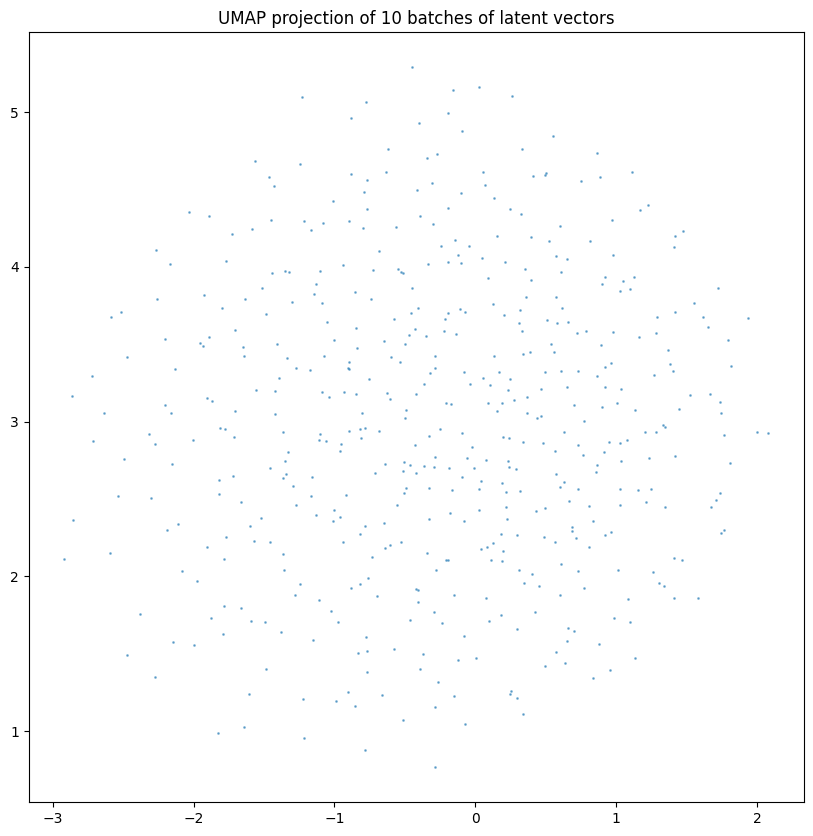

In [22]:
# umap-learn
# pip install umap-learn
import umap
import matplotlib.pyplot as plt
import glob

# Load first N batches
N = 10  # Number of batches to load
batch_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.npy"))[:N]

# Load and concatenate batches
latent_vectors = []
for batch_file in batch_files:
    batch_vectors = np.load(batch_file)
    latent_vectors.append(batch_vectors)
latent_vectors = np.concatenate(latent_vectors, axis=0)

# Remove last 3 columns (sent_idx, tok_idx, token)
latent_vectors = latent_vectors[:, :-3]

print(f"Loaded {len(batch_files)} batches, total shape: {latent_vectors.shape}")

# TODO: do a selection of features (feature of interest, and 100 similar features)

# UMAP dimensionality reduction
umap_embedder = umap.UMAP(n_components=2, metric='cosine')
latent_vectors_2d = umap_embedder.fit_transform(latent_vectors.T)

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], s=1, alpha=0.5)
plt.title(f'UMAP projection of {N} batches of latent vectors')
plt.show()

### Feature specificity

### Feature completness

## Feature search

### Single prompt search

In [25]:
activation_cache = []
def save_activations_hook(module, input, output):
    # input is a tuple; input[0] is the tensor we need
    activation_cache.append(input[0].cpu().detach().numpy())

# Register hook on the 16th layer
layer_index = 15  # Zero-based index; 15 corresponds to the 16th layer
hook_handle = model.model.layers[layer_index].register_forward_hook(save_activations_hook) 

In [30]:
prompt = "in San Francisco, the Golden Gate Bridge was protected at all times by a"

# Tokenize sentence
inputs = tokenizer(
    sentence,
    return_tensors="pt",
    # truncation=True,
    # max_length=512,
    # padding="max_length",
).to(device)

activation_cache = []
# Forward pass
with torch.no_grad():
    model(**inputs)

activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, 1, seq_len, 3072)
activations = activations.squeeze()  # Remove first two dimensions
activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor with float16 dtype

# Get latent vector for sentence
with torch.no_grad():
    _, encoded = model_sae(activations)
    latent_vector = encoded.cpu().numpy() # (seq_len, 1M)

# Apply row softmax normalization
row_softmax = torch.nn.functional.softmax(torch.tensor(latent_vector), dim=1).numpy()

# Sum over sequence length dimension to get feature importance across sentence
feature_importance = np.sum(row_softmax, axis=0)

# Get top 5 features and their values
top_k = 5
top_feature_indices = np.argsort(feature_importance)[-top_k:][::-1]
top_feature_values = feature_importance[top_feature_indices]

print("Top 5 features and their activation values:")
for idx, val in zip(top_feature_indices, top_feature_values):
    print(f"Feature {idx}: {val:.4f}")



Activations shape: (1, 1, 11, 3072)
Top 5 features and their activation values:
Feature 246: 0.2927
Feature 63: 0.2336
Feature 471: 0.1375
Feature 69: 0.1166
Feature 210: 0.0901


Multiple prompts:
 * tokenize to fixed length
 * reshape activations to (num_sent*seq_len, 3072)
 * get attention mask and remove padding tokens
 


In [31]:
prompts = [
    "in San Francisco, the Golden Gate Bridge was protected at all times by a",
    "the Golden Gate Bridge is so beautiful during the sunset", 
    "Golden Gate Bridge wind resistance barriers creates eerie sound"
]

# Tokenize sentences
inputs = tokenizer(
    prompts,
    return_tensors="pt",
    truncation=True,
    max_length=512,
    padding="max_length",
).to(device)

activation_cache = []
# Forward pass
with torch.no_grad():
    model(**inputs)

activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, num_sent, seq_len, 3072)

# Reshape activations to (num_sent*seq_len, 3072)
activations = activations.squeeze(0)  # Remove batch dimension
num_sent, seq_len, hidden_dim = activations.shape
activations = activations.reshape(-1, hidden_dim)

# Get attention mask and remove padding tokens
attention_mask = inputs['attention_mask'].view(-1).cpu().numpy()
activations = activations[attention_mask == 1]

activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor

# Get latent vectors for sentences
with torch.no_grad():
    _, encoded = model_sae(activations)
    latent_vector = encoded.cpu().numpy()

# Apply row softmax normalization
row_softmax = torch.nn.functional.softmax(torch.tensor(latent_vector), dim=1).numpy()

# Sum over sequence length dimension to get feature importance across all sentences
feature_importance = np.sum(row_softmax, axis=0)

# Get top 5 features and their values
top_k = 5
top_feature_indices = np.argsort(feature_importance)[-top_k:][::-1]
top_feature_values = feature_importance[top_feature_indices]

print("Top 5 features and their activation values:")
for idx, val in zip(top_feature_indices, top_feature_values):
    print(f"Feature {idx}: {val:.4f}")


Activations shape: (1, 3, 512, 3072)
Top 5 features and their activation values:
Feature 246: 0.8910
Feature 63: 0.7081
Feature 471: 0.4210
Feature 69: 0.3575
Feature 210: 0.2798


### Prompt combination

add negative prompts

### Generated prompts

In [30]:
# use single/multiple prompt search code above
# prompts generated by LLM
